In [1]:
from interaction_inference import simulation
from interaction_inference import correlation
from interaction_inference import optimization
from interaction_inference import dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import tqdm

In [2]:
rng = np.random.default_rng()

In [3]:
def simulate_dataset(name, interaction_values, gene_values, cells=1000, rate=1, runs=1, tqdm_disable=False):
    '''
    Custom dataset simulation
    '''

    # number of pairs
    gene_pairs = len(interaction_values) * len(gene_values) * runs

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # sample counter
    i = 0

    # for each sample
    for int_val in tqdm.tqdm(interaction_values, disable=tqdm_disable):
        for gene_val in gene_values:
            for k in range(runs):

                # Set reaction rate parameters
                k_on_1 = gene_val
                k_on_2 = gene_val
                k_off_1 = 1 - gene_val
                k_off_2 = 1 - gene_val
                k_tx_1 = rate
                k_tx_2 = rate
                k_deg_1 = 1
                k_deg_2 = 1
                k_reg = int_val

                # store parameters
                params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

                params = {
                    'k_on_1': k_on_1,
                    'k_on_2': k_on_2,
                    'k_off_1': k_off_1,
                    'k_off_2': k_off_2,
                    'k_tx_1': k_tx_1,
                    'k_tx_2': k_tx_2,
                    'k_deg_1': k_deg_1,
                    'k_deg_2': k_deg_2,
                    'k_reg': k_reg
                }

                # simulate sample from model
                sample = simulation.gillespie_telegraph(params, cells)

                # store counts
                counts_df.iloc[i] = sample

                # increment sample
                i += 1

    # construct dataset object
    data = dataset.Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = gene_pairs
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [12]:
def simulate_downsampled(dataset, capture_values):
    '''
    Produce array of downsampled 'dataset' by each capture
    '''

    # downsampled dataset
    data_array = np.empty(len(capture_values), dtype=object)

    # for each capture
    for i, capture in enumerate(capture_values):

        # sample beta
        if capture == 0:
            beta = np.ones(dataset.cells)
        else:
            beta = rng.beta(1, capture, size=dataset.cells)
            beta[beta < 0.01] = 0.01

        # downsample dataset
        downsampled_dataset = dataset.downsample(
            f"dataset-{i}",
            beta
        )

        # store
        data_array[i] = downsampled_dataset

    return data_array

In [5]:
def correlation_array(data_array, interaction_values, capture_values, runs):

    # result shape
    shape = (len(capture_values), len(interaction_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # run correlation test
        corr = correlation.Correlation(
            data,
            tqdm_disable=False,
            printing=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(interaction_values):
            for l in range(runs):

                # get result
                if corr.result_dict[i]['pvalue'] < 0.05:
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [6]:
def moment_array(data_array, interaction_values, capture_values, runs):

    # result shape
    shape = (len(capture_values), len(interaction_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # compute moments
        data.compute_moments(tqdm_disable=False)

        # run moment test
        momt = optimization.Optimization(
            data,
            ["dummy_moment"],
            license_file="C:/WLS_credentials.json",
            tqdm_disable=False,
            print_solution=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(interaction_values):
            for l in range(runs):

                # get result
                if momt.result_dict[i]['status'] == "INFEASIBLE":
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [7]:
def probability_array(data_array, interaction_values, capture_values, runs):

    # result shape
    shape = (len(capture_values), len(interaction_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # compute moments
        data.compute_probabilities(tqdm_disable=False)

        # run moment test
        momt = optimization.Optimization(
            data,
            [
                "marginal_probability",
                "marginal_CME",
                "base"
            ],
            license_file="C:/WLS_credentials.json",
            tqdm_disable=False,
            print_solution=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(interaction_values):
            for l in range(runs):

                # get result
                if momt.result_dict[i]['status'] == "INFEASIBLE":
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [8]:
def downsampled_probability_array(data_array, interaction_values, capture_values, runs):

    # result shape
    shape = (len(capture_values), len(interaction_values))

    # result array
    results = np.zeros(shape)

    # for each downsampled dataset
    for j, data in enumerate(data_array):

        # compute moments
        data.compute_probabilities(tqdm_disable=False)
        data.compute_fm(tqdm_disable=False)

        # run moment test
        momt = optimization.Optimization(
            data,
            [
                "downsampled_marginal_probability",
                "downsampled_marginal_CME",
                "downsampled_marginal_base"
            ],
            license_file="C:/WLS_credentials.json",
            tqdm_disable=False,
            print_solution=False
        )

        # sample counter
        i = 0

        # for each result
        for k, _ in enumerate(interaction_values):
            for l in range(runs):

                # get result
                if momt.result_dict[i]['status'] == "INFEASIBLE":
                    results[j, k] += 1 / runs

                # increment counter
                i += 1

    return results

In [25]:
def plot(array, title, caption, interaction_values, capture_values, figsize=(6, 6)):

    fig, axs = plt.subplots(figsize=figsize)

    #fig.suptitle("Infeasibility %")

    #plt.tight_layout()

    cmap = LinearSegmentedColormap.from_list('br', ["b", "w", "r"], N=256)

    vmin, vmax = 0, 1

    img = axs.imshow(array, cmap=cmap, vmin=vmin, vmax=vmax)
    axs.set_xlabel("Interaction strength")
    axs.set_xticks(range(len(interaction_values)))
    axs.set_xticklabels(interaction_values)
    axs.set_ylabel("Capture b: Beta(1, b)")
    axs.set_yticks(range(len(capture_values)))
    axs.set_yticklabels(capture_values)
    axs.set_title(title)

    cbar = plt.colorbar(img, ax=axs)
    cbar.set_label(caption)

In [10]:
# settings
capture_values = [0, 1, 2, 3, 4, 5, 8, 10, 12, 14, 16, 18, 20]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.8, 0.6, 0.4, 0.2, 0.1, 0]
runs = 10
rate = 5

In [11]:
data = simulate_dataset("dataset-100", interaction_values, [1.0], cells=1000, rate=rate, runs=runs)

100%|██████████| 14/14 [13:32<00:00, 58.06s/it]


In [13]:
data_array = simulate_downsampled(data, capture_values)

In [14]:
corr = correlation_array(data_array, interaction_values, capture_values, runs)

100%|██████████| 140/140 [00:00<00:00, 649.00it/s]


In [15]:
momt = moment_array(data_array, interaction_values, capture_values, runs)

100%|██████████| 140/140 [00:02<00:00, 62.24it/s]


In [23]:
prob = probability_array(data_array, interaction_values, capture_values, runs)

100%|██████████| 140/140 [17:21<00:00,  7.44s/it]


In [18]:
down = downsampled_probability_array(data_array, interaction_values, capture_values, runs)

100%|██████████| 140/140 [00:07<00:00, 19.26it/s]


## Plots

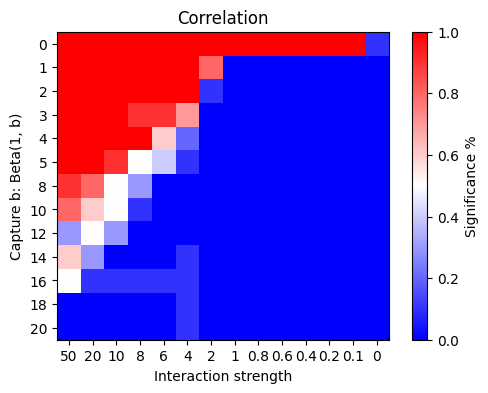

In [26]:
plot(corr, "Correlation", "Significance %", interaction_values, capture_values, figsize=(6, 4))

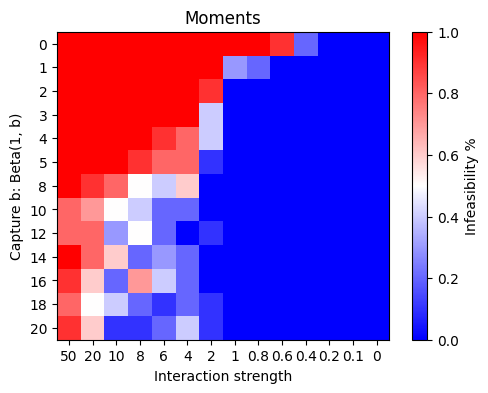

In [27]:
plot(momt, "Moments", "Infeasibility %", interaction_values, capture_values, figsize=(6, 4))

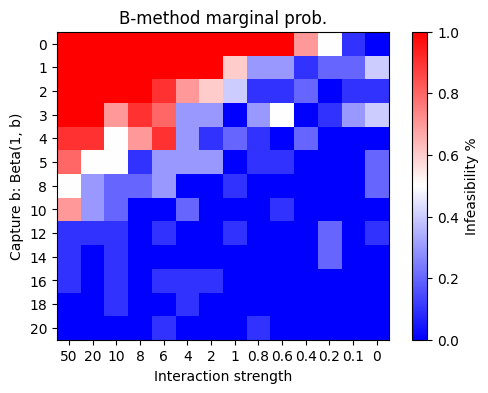

In [28]:
plot(prob, "B-method marginal prob.", "Infeasibility %", interaction_values, capture_values, figsize=(6, 4))

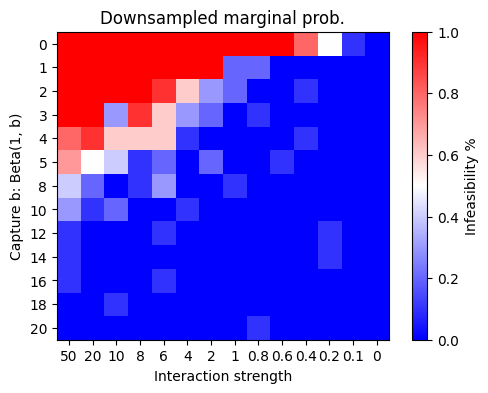

In [29]:
plot(down, "Downsampled marginal prob.", "Infeasibility %", interaction_values, capture_values, figsize=(6, 4))